In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math

# carica i dati dal file CSV
data = pd.read_csv('./scalars_WP.csv')

In [2]:
#Controllo gli scalari a disposizione
data.name.unique(), data.module.unique()

(array([nan, 'created:last', 'queueingTime:mean', 'queueingTime:max',
        'queueLength:timeavg', 'queueLength:max', 'dropped:count',
        'busy:timeavg', 'generation:mean', 'generation:max',
        'delaysVisited:mean', 'delaysVisited:max', 'queuesVisited:mean',
        'queuesVisited:max', 'totalServiceTime:mean',
        'totalServiceTime:max', 'totalDelayTime:mean',
        'totalDelayTime:max', 'totalQueueingTime:mean',
        'totalQueueingTime:max', 'lifeTime:mean', 'lifeTime:max',
        'typename', 'numJobs', 'interArrivalTime', 'jobName', 'jobType',
        'jobPriority', 'startTime', 'stopTime', 'capacity', 'fifo',
        'sendingAlgorithm', 'Threshold', 'fetchingAlgorithm',
        'serviceTime', 'serviceTime_2', 'switchOverTime', 'keepJobs'],
       dtype=object),
 array([nan, 'Network.S1', 'Network.S2', 'Network.first', 'Network.second',
        'Network.servente', 'Network.sink', 'Network.sink1', 'Network'],
       dtype=object))

In [3]:
def mean_CI(elem):
    #Trasformo elem in un array
    elemAsArray = np.asarray(elem[['value']],dtype=np.float64)
    #Rimuovo eventuali NaN
    elemAsArray = elemAsArray[np.isfinite(elemAsArray)]
    #Calcolo la media degli elementi
    elemMean = elemAsArray.mean()

    #https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
    #Calcolo la deviazione standard
    stdDev = np.std(elemAsArray)
    #Calcolo degli intervalli di confidenza al 95%
    CI = st.norm.interval(0.95, loc=elemMean, scale=stdDev/math.sqrt(len(elemAsArray)))
    
    print(f"Mean: {elemMean:.4f}, 95% CI: ({CI[0]:.4f}, {CI[1]:.4f})")
    
    return elemMean, CI

In [4]:
def two_mean_CI(elem1,elem2):
    #Unisco i due array
    npallvalues = np.append(np.asarray(elem1[['value']],dtype=np.float64),np.asarray(elem2[['value']],dtype=np.float64))
    #Rimuovo eventuali NaN
    npallvalues = npallvalues[np.isfinite(npallvalues)]
    #Calcolo la media totale
    allvalmean = npallvalues.mean()
    #Calcolo la deviazione standard
    stddevallval = np.std(npallvalues)
    #Calcolo degli intervalli di confidenza al 95%
    confidenza_all = st.norm.interval(0.95, loc=allvalmean, scale=stddevallval/math.sqrt(len(npallvalues)))

    print(f"General mean: {allvalmean:.4f}, 95% CI: ({confidenza_all[0]:.4f}, {confidenza_all[1]:.4f})")
    
    return allvalmean, confidenza_all

In [5]:
def plt_scalar(elem, CI, label):
    #Trasformo elem in un array
    elemAsArray = np.asarray(elem[['value']],dtype=np.float64)
    #Rimuovo eventuali NaN
    elemAsArray = elemAsArray[np.isfinite(elemAsArray)]
    
    #Grafico dei valori
    plt.plot(range(len(elemAsArray)), elemAsArray)
    #Aggiungo intervallo di confidenza
    plt.axhline(y=CI[0], color='r', linestyle='--')
    plt.axhline(y=CI[1], color='r', linestyle='--')

    plt.xlabel("Run")
    plt.ylabel(label)
    plt.savefig(label + ".png")
    plt.show()

In [6]:
def plot_groups(dati, label):
    # Divido i dati in gruppi di 20 elementi
    dati = np.asarray(dati[['value']],dtype=np.float64)
    dati = dati[np.isfinite(dati)]
    
    data_split = np.array_split(dati, len(dati) // 20)
    
    # Creo i grafici
    for i, group in enumerate(data_split):
        plt.figure(figsize=(5, 5))
        plt.plot(range(len(group)), group)
        plt.xticks(range(20))
        plt.xlabel("Run")
        plt.ylabel(label)
        plt.show()

In [7]:
def plot_groups_with_CI(data, label):
    # Divido i dati in gruppi di 20 elementi
    data = np.asarray(data[['value']],dtype=np.float64)
    data_split = np.array_split(data, len(data) // 20)
    
    # Calcolo media, deviazione standard e intervalli di confidenza per ogni gruppo
    means = [np.mean(group) for group in data_split]
    stds = [np.std(group) for group in data_split]
    CIs = [st.norm.interval(0.95, loc=mean, scale=std / math.sqrt(len(group))) for mean, std, group in zip(means, stds, data_split)]
    
    # Creo i grafici
    for i, (group, mean, std, CI) in enumerate(zip(data_split, means, stds, CIs)):
        plt.figure(figsize=(5, 5))
        plt.plot(range(len(group)), group)
        plt.xticks(range(20))
        plt.axhline(y=CI[0], color='r', linestyle='--')
        plt.axhline(y=CI[1], color='r', linestyle='--')
        plt.xlabel("Run")
        plt.ylabel(label)
        plt.show()

In [8]:


#Numero medio di utenti persi



Mean: 195.8000, 95% CI: (142.9413, 248.6587)


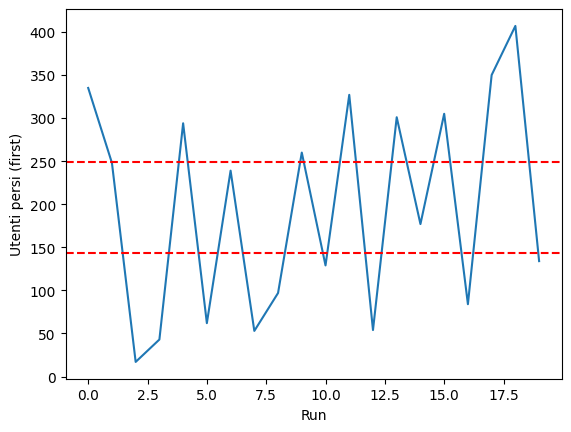

In [9]:
dropped1 = data[(data.type=='scalar') & (data.module=='Network.first') & (data.name=='dropped:count')]
dropped1_mean, dropped1_CI= mean_CI(dropped1)
plt_scalar(dropped1,dropped1_CI,"Utenti persi (first)")

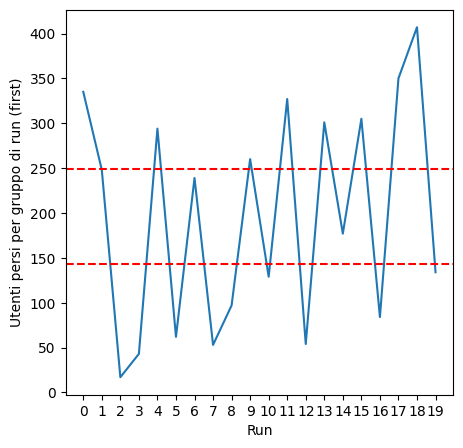

In [10]:
plot_groups_with_CI(dropped1,"Utenti persi per gruppo di run (first)")

In [11]:
#Mi aspetto siano tutti 0 (la seconda coda ha capacità infinita)
dropped2 = data[(data.type=='scalar') & (data.module=='Network.second') & (data.name=='dropped:count')]
#Se sono tutti 0 non calcolo
if np.count_nonzero(dropped2[['value']]) == 0:
    dropped2_mean, dropped2_CI= mean_CI(dropped2)
    plt_scalar(dropped2,dropped2_CI,"Utenti persi (second)")

In [12]:
#plot_groups_with_CI(dropped2,"Utenti persi per gruppo di run (second)")

In [13]:
dropped_mean, dropped_CI = two_mean_CI(dropped1, dropped2)

General mean: 97.9000, 95% CI: (57.6637, 138.1363)


In [14]:


#Tempo medio di permanenza (s)



Mean: 3.6975, 95% CI: (3.2458, 4.1491)


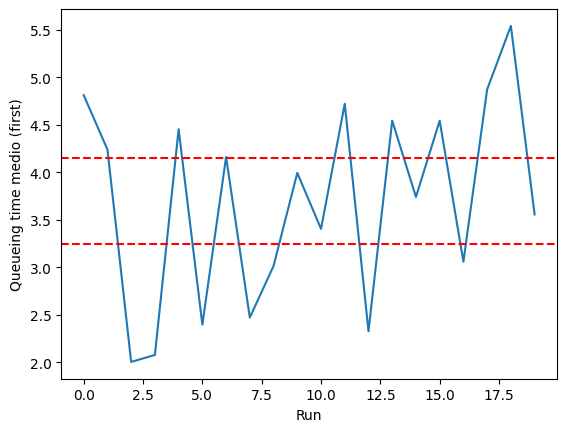

In [15]:
first_queue_time = data[(data.type=='scalar') &(data.module == 'Network.first') & (data.name == 'queueingTime:mean')]

time1_mean, time1_CI= mean_CI(first_queue_time)
plt_scalar(first_queue_time,time1_CI,"Queueing time medio (first)")

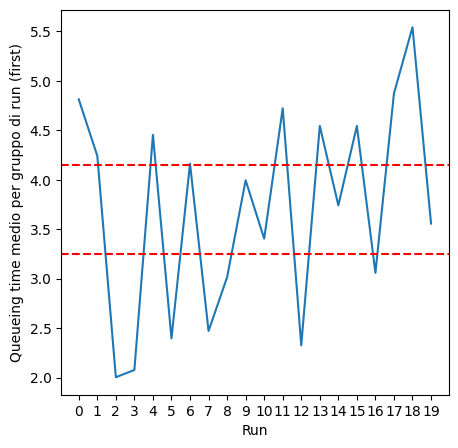

In [16]:
plot_groups_with_CI(first_queue_time,"Queueing time medio per gruppo di run (first)")

Mean: 0.8036, 95% CI: (0.7512, 0.8561)


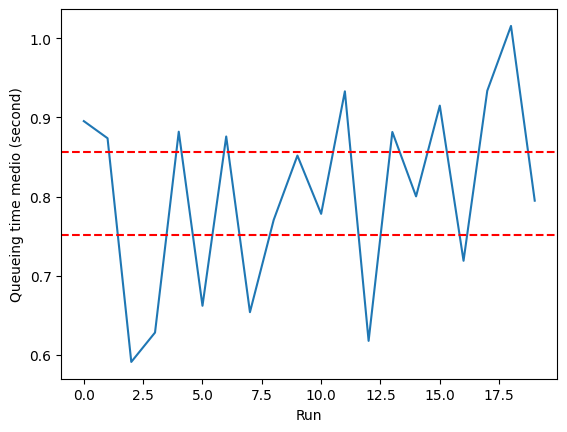

In [17]:
second_queue_time = data[(data.type=='scalar') &(data.module == 'Network.second') & (data.name == 'queueingTime:mean')]

time2_mean, time2_CI= mean_CI(second_queue_time)
plt_scalar(second_queue_time,time2_CI,"Queueing time medio (second)")

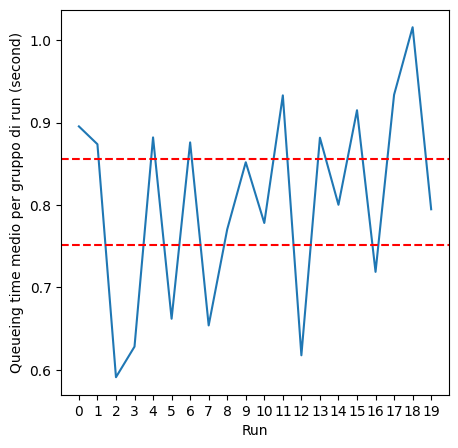

In [18]:
plot_groups_with_CI(second_queue_time,"Queueing time medio per gruppo di run (second)")

In [19]:
time_mean, time_CI = two_mean_CI(first_queue_time, second_queue_time)

General mean: 2.2505, 95% CI: (1.7478, 2.7533)


In [20]:


#Numero medio di presenza (utenti)



Mean: 3.2893, 95% CI: (2.8890, 3.6896)


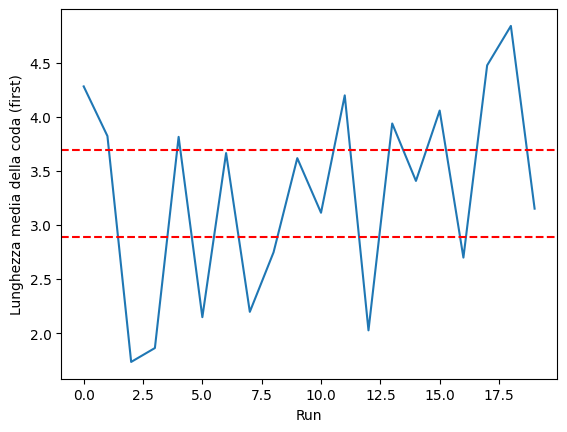

In [21]:
first_queue_L = data[(data.type=='scalar') &(data.module == 'Network.first') & (data.name == 'queueLength:timeavg')]

L1_mean, L1_CI= mean_CI(first_queue_L)
plt_scalar(first_queue_L, L1_CI, "Lunghezza media della coda (first)")


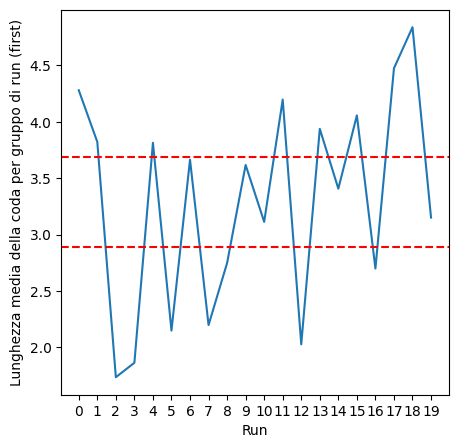

In [22]:
plot_groups_with_CI(first_queue_L,"Lunghezza media della coda per gruppo di run (first)")

Mean: 1.5189, 95% CI: (1.4008, 1.6370)


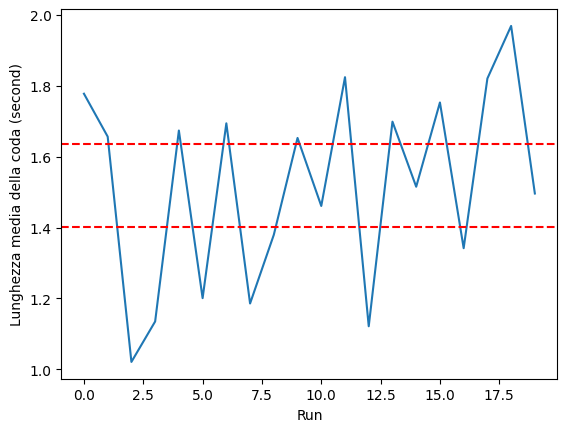

In [23]:
second_queue_L = data[(data.type=='scalar') &(data.module == 'Network.second') & (data.name == 'queueLength:timeavg')]

L2_mean, L2_CI= mean_CI(second_queue_L)
plt_scalar(second_queue_L,L2_CI,"Lunghezza media della coda (second)")


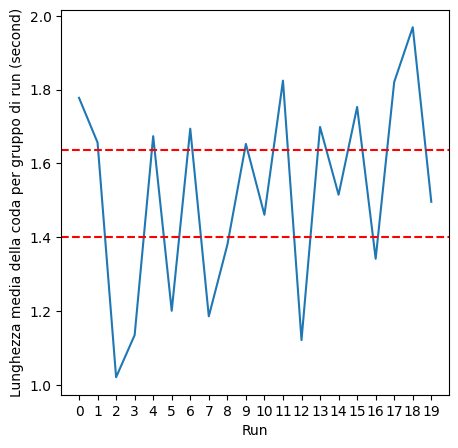

In [24]:
plot_groups_with_CI(second_queue_L,"Lunghezza media della coda per gruppo di run (second)")

In [25]:
L_mean, L_CI = two_mean_CI(first_queue_L, second_queue_L)

General mean: 2.4041, 95% CI: (2.0595, 2.7488)


In [26]:


#Dati prodotti dai sink (sink fa riferimento a first, sink1 a second)



In [27]:
#Tempo medio in coda dei job (s)

Mean: 3.5201, 95% CI: (3.0587, 3.9815)


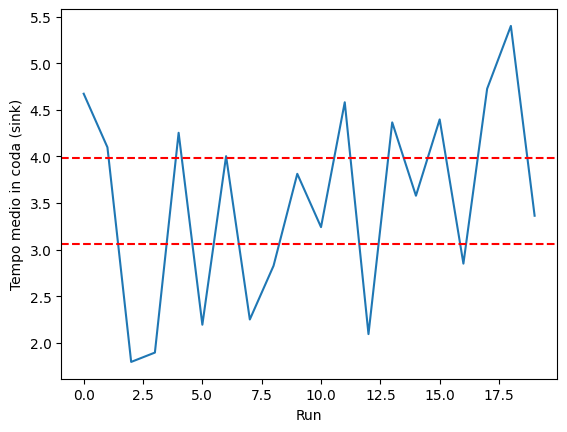

In [28]:
sink1_QTime = data[(data.type=='scalar') &(data.module == 'Network.sink') & (data.name == 'totalQueueingTime:mean')]

sink1_QTime_mean, sink1_QTime_CI= mean_CI(sink1_QTime)
plt_scalar(sink1_QTime,sink1_QTime_CI,"Tempo medio in coda (sink)")

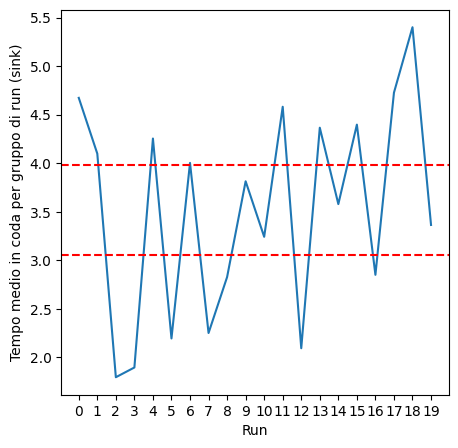

In [29]:
plot_groups_with_CI(sink1_QTime,"Tempo medio in coda per gruppo di run (sink)")

Mean: 0.7519, 95% CI: (0.6939, 0.8099)


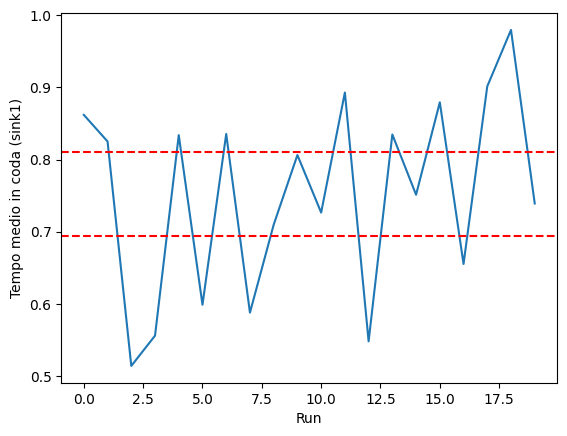

In [30]:
sink2_QTime = data[(data.type=='scalar') &(data.module == 'Network.sink1') & (data.name == 'totalQueueingTime:mean')]

sink2_QTime_mean, sink2_QTime_CI= mean_CI(sink2_QTime)
plt_scalar(sink2_QTime,sink2_QTime_CI,"Tempo medio in coda (sink1)")

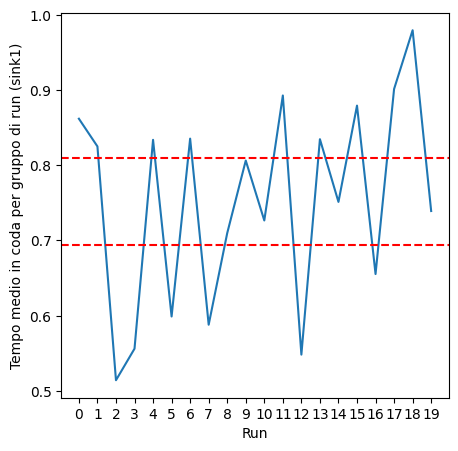

In [31]:
plot_groups_with_CI(sink2_QTime,"Tempo medio in coda per gruppo di run (sink1)")

In [32]:
sinksQtime_mean, sinksQtime_CI = two_mean_CI(sink1_QTime, sink2_QTime)

General mean: 2.1360, 95% CI: (1.6481, 2.6239)


In [33]:
#Tempo medio di servizio dei job (s)

Mean: 0.3300, 95% CI: (0.3297, 0.3303)


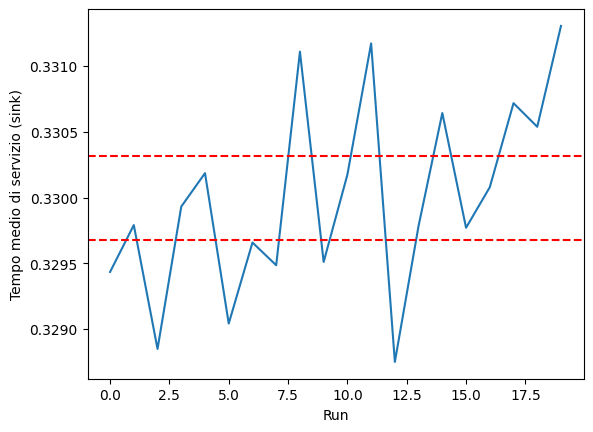

In [34]:
sink1_STime = data[(data.type=='scalar') &(data.module == 'Network.sink') & (data.name == 'totalServiceTime:mean')]

sink1_STime_mean, sink1_STime_CI = mean_CI(sink1_STime)
plt_scalar(sink1_STime,sink1_STime_CI,"Tempo medio di servizio (sink)")

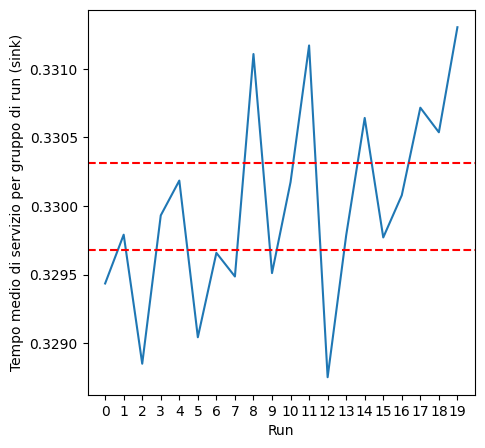

In [35]:
plot_groups_with_CI(sink1_STime,"Tempo medio di servizio per gruppo di run (sink)")

Mean: 0.2499, 95% CI: (0.2498, 0.2501)


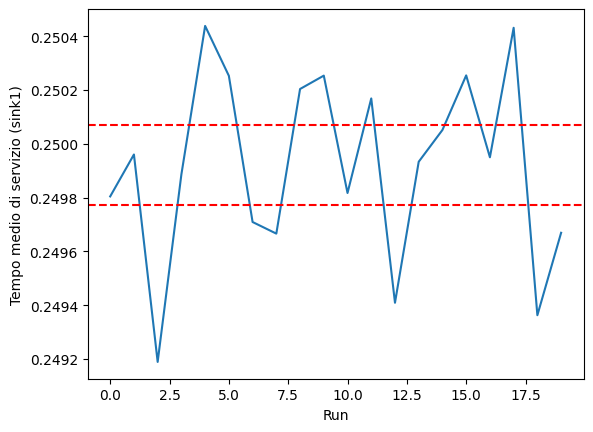

In [36]:
sink2_STime = data[(data.type=='scalar') &(data.module == 'Network.sink1') & (data.name == 'totalServiceTime:mean')]

sink2_STime_mean, sink2_STime_CI= mean_CI(sink2_STime)
plt_scalar(sink2_STime,sink2_STime_CI,"Tempo medio di servizio (sink1)")

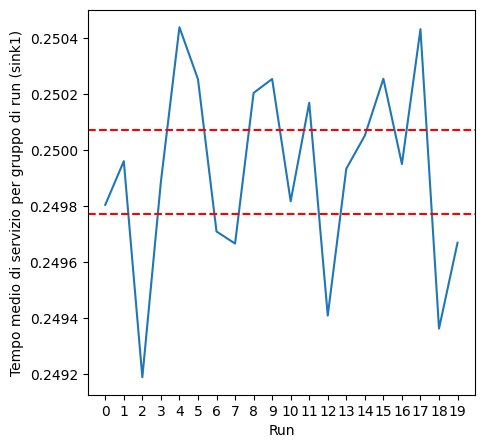

In [37]:
plot_groups_with_CI(sink2_STime,"Tempo medio di servizio per gruppo di run (sink1)")

In [38]:
sinksStime_mean, sinksStime_CI = two_mean_CI(sink1_STime, sink2_STime)

General mean: 0.2900, 95% CI: (0.2775, 0.3024)


In [39]:
#Tempo medio di vita dei job (s)

Mean: 3.8501, 95% CI: (3.3886, 4.3117)


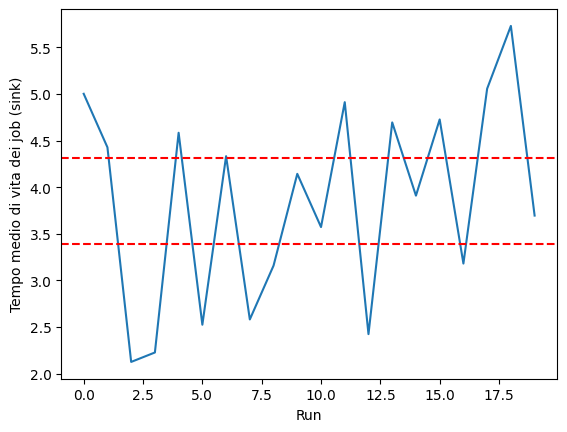

In [40]:
sink1_LT_Time = data[(data.type=='scalar') &(data.module == 'Network.sink') & (data.name == 'lifeTime:mean')]

sink1_LT_Time_mean, sink1_LT_Time_CI = mean_CI(sink1_LT_Time)
plt_scalar(sink1_LT_Time,sink1_LT_Time_CI,"Tempo medio di vita dei job (sink)")

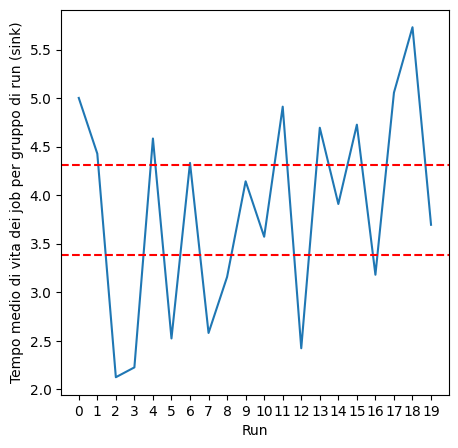

In [41]:
plot_groups_with_CI(sink1_LT_Time,"Tempo medio di vita dei job per gruppo di run (sink)")

Mean: 1.0018, 95% CI: (0.9438, 1.0599)


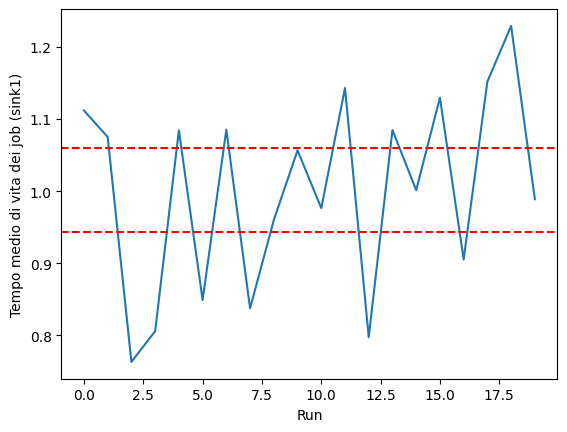

In [42]:
sink2_LT_Time = data[(data.type=='scalar') &(data.module == 'Network.sink1') & (data.name == 'lifeTime:mean')]

sink2_LT_Time_mean, sink2_LT_Time_CI = mean_CI(sink2_LT_Time)
plt_scalar(sink2_LT_Time,sink2_LT_Time_CI,"Tempo medio di vita dei job (sink1)")

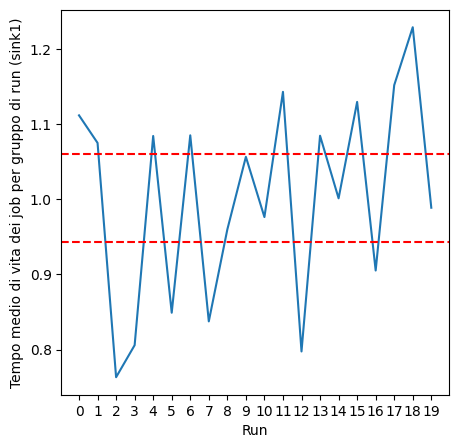

In [43]:
plot_groups_with_CI(sink2_LT_Time,"Tempo medio di vita dei job per gruppo di run (sink1)")

In [44]:
sinks_LT_time_mean, sinks_LT_time_CI = two_mean_CI(sink1_LT_Time, sink2_LT_Time)

General mean: 2.4260, 95% CI: (1.9271, 2.9249)


In [45]:


#Servente



Mean: 0.8150, 95% CI: (0.8107, 0.8193)


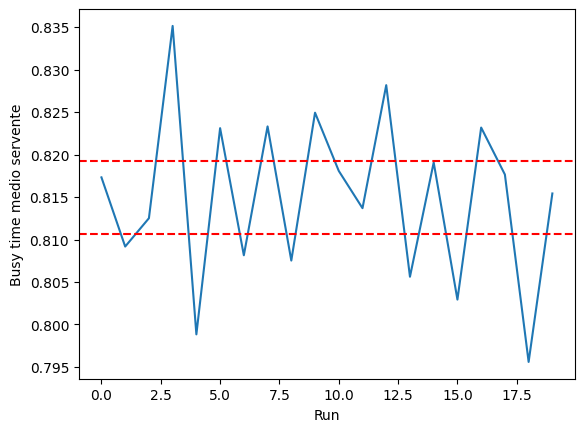

In [46]:
servente_busy_time = data[(data.type=='scalar') &(data.module == 'Network.servente') & (data.name == 'busy:timeavg')]

servente_busy_time_mean, servente_busy_time_CI = mean_CI(servente_busy_time)
plt_scalar(servente_busy_time,servente_busy_time_CI,"Busy time medio servente")

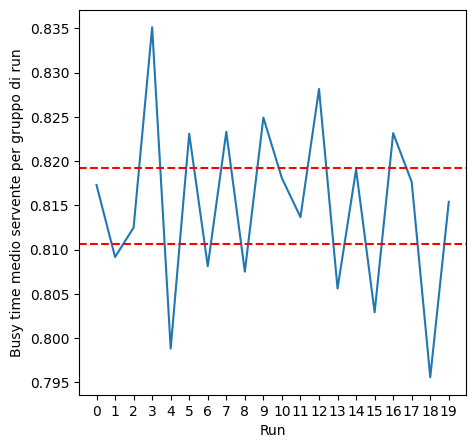

In [47]:
plot_groups_with_CI(servente_busy_time,"Busy time medio servente per gruppo di run")

In [48]:



#Vettori




In [49]:
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

In [50]:
#Importo i vettori
dataV = pd.read_csv('./vectors_WP.csv', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})
dataV.name.unique(), dataV.module.unique()

(array([nan, 'queueLength:vector', 'lifeTime:vector'], dtype=object),
 array([nan, 'Network.second', 'Network.sink1', 'Network.first',
        'Network.sink'], dtype=object))

In [51]:
def running_avg(x):
    return np.cumsum(x) / np.arange(1, x.size + 1)

def running_timeavg(t,x):
    dt = t[1:] - t[:-1]
    return np.cumsum(x[:-1] * dt) / t[1:]

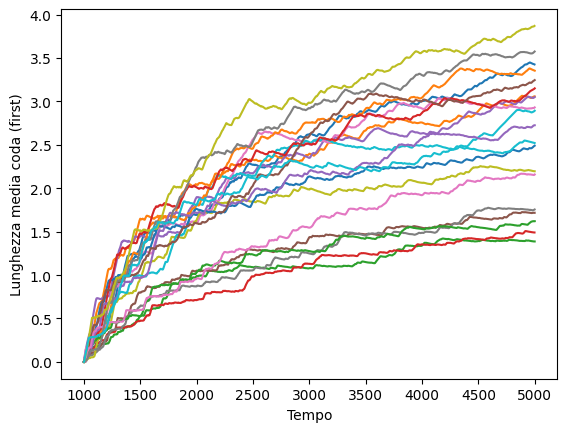

In [52]:
vec = dataV[(dataV.type=='vector') &(dataV.module == 'Network.first') & (dataV.name == 'queueLength:vector')]
for row in vec.itertuples():
    plt.plot(row.vectime[1:], running_timeavg(row.vectime,row.vecvalue))

plt.xlabel("Tempo")
plt.ylabel("Lunghezza media coda (first)")
#plt.vlines(x=100, ymin=0, ymax=10,color='r', linestyle='-')
plt.savefig("WP_QueueLength_1.png")
plt.show()

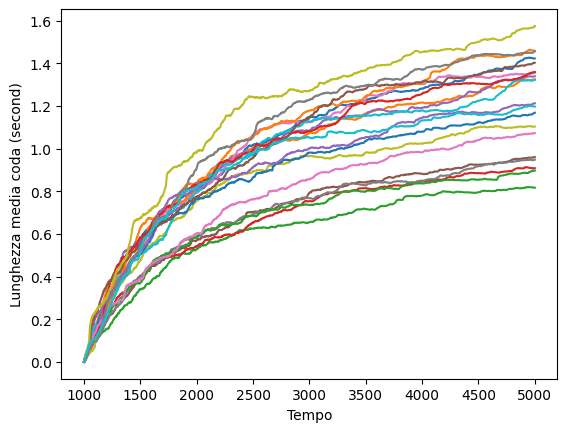

In [53]:
vec = dataV[(dataV.type=='vector') &(dataV.module == 'Network.second') & (dataV.name == 'queueLength:vector')]
for row in vec.itertuples():
    plt.plot(row.vectime[1:], running_timeavg(row.vectime,row.vecvalue))

plt.xlabel("Tempo")
plt.ylabel("Lunghezza media coda (second)")
#plt.vlines(x=100, ymin=0, ymax=2000,color='r', linestyle='-')
plt.savefig("WP_QueueLength_2.png")
plt.show()

In [54]:
#lifetime of arrived jobs

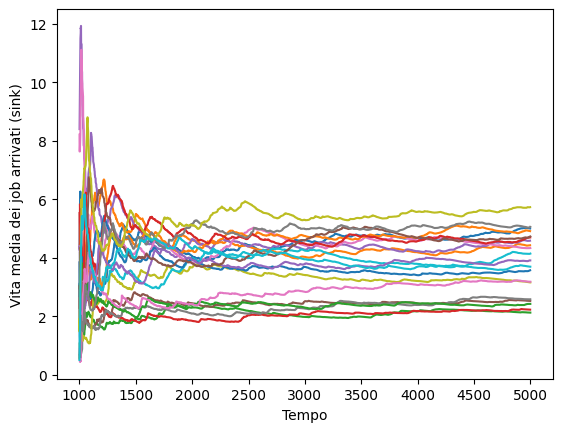

In [55]:
vec = dataV[(dataV.type=='vector') &(dataV.module == 'Network.sink') & (dataV.name == 'lifeTime:vector')]
for row in vec.itertuples():
    plt.plot(row.vectime, running_avg(row.vecvalue))
    
plt.xlabel("Tempo")
plt.ylabel("Vita media dei job arrivati (sink)")
#plt.vlines(x=100, ymin=0, ymax=600,color='r', linestyle='-')
plt.savefig("WP_VitaMedia_1.png")
plt.show()

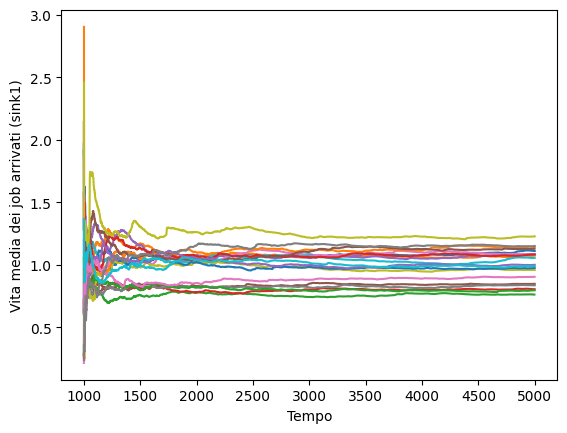

In [56]:
vec = dataV[(dataV.type=='vector') &(dataV.module == 'Network.sink1') & (dataV.name == 'lifeTime:vector')]
for row in vec.itertuples():
    plt.plot(row.vectime, running_avg(row.vecvalue))
    
plt.xlabel("Tempo")
plt.ylabel("Vita media dei job arrivati (sink1)")
#plt.vlines(x=100, ymin=0, ymax=800,color='r', linestyle='-')
plt.savefig("WP_VitaMedia_2.png")

plt.show()